# Google colab: 
### https://colab.research.google.com/notebooks/intro.ipynb#scrollTo=-Rh3-Vt9Nev9
* You need a google account to use colab

### MNIST dataset in PyTorch:
#### https://pytorch.org/docs/stable/torchvision/datasets.html#mnist

### Read more about the MNIST dataset here: 
#### http://yann.lecun.com/exdb/mnist/

## Why use google colab and not jupyter notebook on localhost?
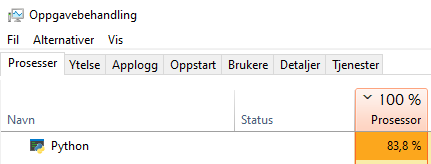
* <b>If you run the code below in jupyter notebook on localhost it will take about 10-30min depending on your computer. </b>
* <b>If you run it in google colab it takes about 1min. </b>
### Google colab GPU up to 35x faster than CPU
You can use GPU as a backend for free for 12 hours at a time. The 12-hour limit is for a continuous assignment of VM. It means we can use GPU compute even after the end of 12 hours by connecting to a different VM. This means that if your model takes longer than 12 hours to train, you should not be using the free google colab (can upgrade to colab Pro). 

## Neural Networks
* Page 106-120 in Introduction to Machine Learning with Python

#### Neural Networks Explained: 
* https://www.youtube.com/watch?v=py5byOOHZM8
* https://www.youtube.com/watch?v=aircAruvnKk
* https://www.youtube.com/watch?v=BzcBsTou0C0

# Run this code in google colab: 
* Download this notebook
* Click the link to google colab: https://colab.research.google.com/notebooks/intro.ipynb#scrollTo=-Rh3-Vt9Nev9
* Click on "File" in the upper left corner, go to "Open notebook...", choose "Upload" and open this notebook in google colab and run it

In [1]:
!pip3 install torch==1.4.0+cu92 torchvision==0.5.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [3]:
BATCH_SIZE = 32

## transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

## download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw
Processing...
Done!


In [4]:
class NnDigitsClassifier(nn.Module):
    def __init__(self):
        super(NnDigitsClassifier, self).__init__()

        # 28x28x1 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(26 * 26 * 32, 128)
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        # 32x1x28x28 => 32x32x26x26
        x = self.conv1(x)
        x = F.relu(x)

        # flatten => 32 x (32*26*26)
        x = x.flatten(start_dim = 1)

        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        x = F.relu(x)

        # logits => 32x10
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

In [5]:
## test the model with 1 batch
model = NnDigitsClassifier()
for images, labels in trainloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


In [6]:
learning_rate = 0.001
num_epochs = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = NnDigitsClassifier()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [7]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i)) 

Epoch: 0 | Loss: 1.5657 | Train Accuracy: 90.03
Epoch: 1 | Loss: 1.4915 | Train Accuracy: 97.31
Epoch: 2 | Loss: 1.4819 | Train Accuracy: 98.21
Epoch: 3 | Loss: 1.4764 | Train Accuracy: 98.71
Epoch: 4 | Loss: 1.4738 | Train Accuracy: 98.96


In [8]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 98.49
